In [1]:
# for dl modeling
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import torch.nn as nn

# for data processing
import pandas as pd

# for numerical processing
import numpy as np
import scipy.stats as stats

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# for calculating time
import time

In [2]:
# read in data
df = pd.read_csv("data\winequality-red.csv", sep=';')

# remove outliers
df = df[df['total sulfur dioxide'] < 200]

# zscore all cols except quality
cols2train = df.keys()
cols2train = cols2train.drop('quality')
for col in cols2train:
    df[col] = stats.zscore(df[col])

# converting to binary classification
df['quality'] = df['quality'].apply(lambda x: 1 if x >= 6 else 0)

# organise data
data = torch.tensor(df[cols2train].values).float()
labels = torch.tensor(df['quality'].values).float()
# making the labels 2D
labels = labels.unsqueeze(1)

# train test split
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=42)

# making train and test datasets
train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)

print(f"Size of train dataset: {len(train_dataset)}")
print(f"Size of test dataset: {len(test_dataset)}")

Size of train dataset: 1277
Size of test dataset: 320


In [3]:
# making dataloaders
def create_dataloaders(batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True)
    return train_loader, test_loader

In [25]:
# ANN model
class ANN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.input = nn.Linear(input_dim, 32)
        self.fc1 = nn.Linear(32, 64)
        self.fc2 = nn.Linear(64, 32)
        self.output = nn.Linear(32, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.input(x)
        x = self.relu(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.output(x)
        return x

In [26]:
# test the model
model = ANN(input_dim=train_data.shape[1], output_dim=1)
print(model)

ANN(
  (input): Linear(in_features=11, out_features=32, bias=True)
  (fc1): Linear(in_features=32, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
)


In [27]:
# create model
def create_model(input_dim, output_dim):
    model = ANN(input_dim, output_dim)
    optmizer = torch.optim.SGD(model.parameters(), lr=0.01)
    loss_fn = nn.BCEWithLogitsLoss()
    return model, optmizer, loss_fn

In [28]:
# train model function
def train_model(model, optimizer, loss_fn, train_dataloader, test_dataloader, epochs=100):
    train_acc = np.zeros(epochs)
    test_acc = np.zeros(epochs)

    for epoch in range(epochs):
        # training
        model.train()
        batch_acc = []
        for inputs, labels in train_dataloader:
            preds = model(inputs)
            loss = loss_fn(preds, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            batch_acc.append(100 * torch.mean(((preds > 0) == labels).float()).item())

        # training accuracy
        train_acc[epoch] = np.mean(batch_acc)

        # testing
        model.eval()
        with torch.no_grad():
            inputs, labels = next(iter(test_dataloader))
            preds = model(inputs)
            test_acc[epoch] = 100 * torch.mean(((preds > 0) == labels).float()).item()

    return train_acc, test_acc

In [29]:
# train model
epochs = 500
train_dataloader, test_dataloader = create_dataloaders(batch_size=32)
model, optimizer, loss_fn = create_model(input_dim=train_data.shape[1], output_dim=1)
train_acc, test_acc = train_model(
    model, optimizer, loss_fn, train_dataloader, test_dataloader, epochs
)

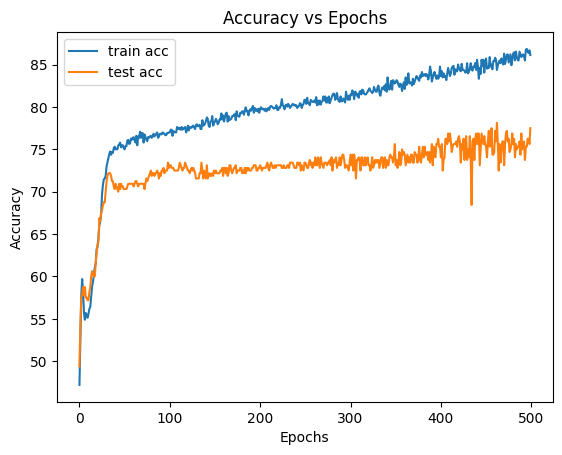

In [30]:
# plot results
plt.plot(train_acc, label="train acc")
plt.plot(test_acc, label="test acc")
plt.title("Accuracy vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [31]:
# smoothing function
def smooth(x, k):
    return np.convolve(x, np.ones(k) / k, mode="same")

In [37]:
# expiriment batch sizes
epochs = 100
batch_sizes = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
results_train_acc = np.zeros((len(batch_sizes), epochs))
results_test_acc = np.zeros((len(batch_sizes), epochs))
comptime = np.zeros(len(batch_sizes))
for i, batch_size in enumerate(batch_sizes):
    starttime = time.process_time()
    train_loader, test_loader = create_dataloaders(batch_size)
    model, optimizer, lossFun = create_model(input_dim=train_data.shape[1], output_dim=1)
    train_acc, test_acc = train_model(model, optimizer, lossFun, train_loader, test_loader, epochs)
    results_train_acc[i] = smooth(train_acc, 5)
    results_test_acc[i] = smooth(test_acc, 5)
    comptime[i] = time.process_time() - starttime
    print(f"batch size: {batch_size}, train accuracy: {train_acc[-1]:.2f}")

batch size: 5, train accuracy: 84.08
batch size: 10, train accuracy: 80.08
batch size: 15, train accuracy: 79.06
batch size: 20, train accuracy: 78.02
batch size: 25, train accuracy: 77.73
batch size: 30, train accuracy: 77.46
batch size: 35, train accuracy: 77.22
batch size: 40, train accuracy: 75.73
batch size: 45, train accuracy: 76.90
batch size: 50, train accuracy: 77.44


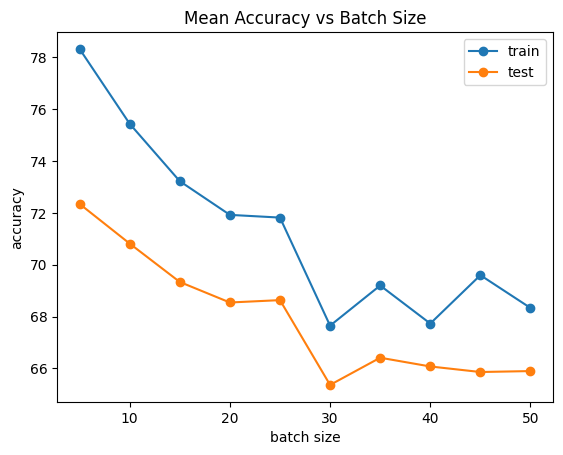

In [38]:
# plot batch size vs mean accuracy
plt.plot(batch_sizes, np.mean(results_train_acc, axis=1), label="train", marker="o")
plt.plot(batch_sizes, np.mean(results_test_acc, axis=1), label="test", marker="o")
plt.title("Mean Accuracy vs Batch Size")
plt.xlabel("batch size")
plt.ylabel("accuracy")
plt.legend()
plt.show()

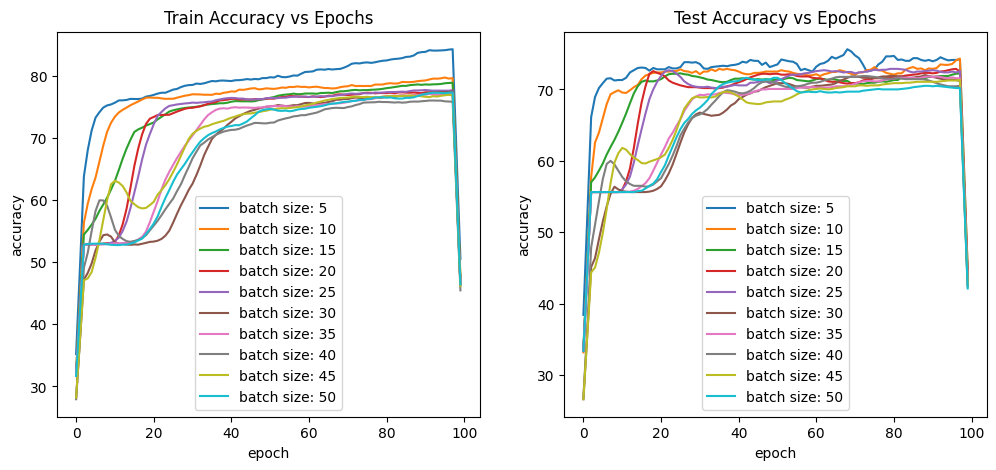

In [39]:
# plot batch size vs accuracy for each epoch
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title("Train Accuracy vs Epochs")
for i, batch_size in enumerate(batch_sizes):
    plt.plot(range(epochs), results_train_acc[i], label=f"batch size: {batch_size}")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()

# plot for test
plt.subplot(1, 2, 2)
plt.title("Test Accuracy vs Epochs")
for i, batch_size in enumerate(batch_sizes):
    plt.plot(range(epochs), results_test_acc[i], label=f"batch size: {batch_size}")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()

plt.show()

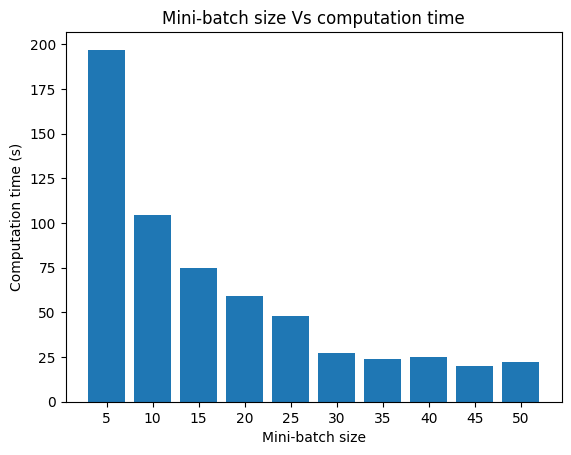

In [40]:
# bar plot of computation time
plt.bar(range(len(comptime)), comptime, tick_label=batch_sizes)
plt.title("Mini-batch size Vs computation time")
plt.xlabel("Mini-batch size")
plt.ylabel("Computation time (s)")
plt.show()